<a href="https://colab.research.google.com/github/daayvm/DiplomadoCD/blob/main/practica_2_velasco_martell_dayra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Módulo III - Práctica II - Velasco Martell Dayra

**Contexto**

Se tienen tres tablas con información de Airbnb Nueva York: reseñas de los huéspedes, características de los alojamientos y costos en diferentes periodos del tiempo.

**Obejtivo**

Nuestra pregunta de *interés* es: ¿Podemos encontrar listados similares de Airbnb basados en lo que ofrecen?

Bibliotecas Generales

In [1]:
# Install missing libraries
!pip install factor-analyzer
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor-analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42655 sha256=bbec21e02159cdcd34dc6b9cbbb915493122dd104f6907197db4cd1957f7f40a
  Stored in directory: /root/.cache/pip/wheels/a2/af/06/f4d4ed4d9d714fda437fb1583629417319603c2266e7b233cc
Successfully built factor-analyzer
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 kB 18.4 MB/s eta 0:00:00


In [2]:
#Archivos desde mi drive
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Valores atipicos
from pyod.models.iforest import IForest

# Preprocesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

Mounted at /content/drive


In [3]:
# Paleta de colores
PALETTE_C = {
    "primary":   "#4C72B0",
    "secondary": "#DD8452",
    "accent":    "#55A868",
    "light":     "#C44E52",
    "background":"#FFFFFF"
}

FACTOR_COLORS = [
    "#4C72B0",
    "#DD8452",
    "#6B8E23",
    "#8B5A2B",
    "#6A5ACD",
]

Carga de datos

1. Tabla Calendar

In [4]:
calendar = pd.read_csv("/content/drive/MyDrive/Diplomado/calendar.csv")
calendar

listing_id        date available    price adjusted_price  \
0               2595  2021-12-05         f  $150.00        $150.00   
1              65615  2021-12-05         f   $85.00         $85.00   
2              65615  2021-12-06         f   $85.00         $85.00   
3              65615  2021-12-07         f   $85.00         $85.00   
4              65615  2021-12-08         f   $85.00         $85.00   
...              ...         ...       ...      ...            ...   
13964530    51781100  2022-11-30         t  $300.00        $300.00   
13964531    51781100  2022-12-01         t  $300.00        $300.00   
13964532    51781100  2022-12-02         t  $300.00        $300.00   
13964533    51781100  2022-12-03         t  $300.00        $300.00   
13964534    51781100  2022-12-04         t  $300.00        $300.00   

          minimum_nights  maximum_nights  
0                   30.0          1125.0  
1                   10.0          1125.0  
2                   10.0          1125.0  
3                   10.0          1125.0  
4                   10.0          1125.0  
...                  ...             ...  
13964530             1.0           365.0  
13964531             1.0           365.0  
13964532             1.0           365.0  
13964533             1.0           365.0  
13964534             1.0           365.0  

[13964535 rows x 7 columns]

In [5]:
#Tipos de datos dentro de la tabla
calendar.dtypes

listing_id          int64
date               object
available          object
price              object
adjusted_price     object
minimum_nights    float64
maximum_nights    float64
dtype: object

Información de las variables Calendar

*   listing_id: identificador del alojamiento

*   date: fecha

*   available: disponibilidad del alojamiento (t/f)

*   price: precio por noche

*   adjusted_price: precio ajustado

*   minimum_nights: mínimo de noches

*   maximum_nights: máximo de noches

2. Tabla Listings

In [6]:
listing = pd.read_csv("/content/drive/MyDrive/Diplomado/listings.csv")
listing

/tmp/ipython-input-1124196019.py:1: DtypeWarning: Columns (67) have mixed types. Specify dtype option on import or set low_memory=False.
  listing = pd.read_csv("/content/drive/MyDrive/Diplomado/listings.csv")


id                            listing_url       scrape_id  \
0          2595      https://www.airbnb.com/rooms/2595  20211204143024   
1          3831      https://www.airbnb.com/rooms/3831  20211204143024   
2          5121      https://www.airbnb.com/rooms/5121  20211204143024   
3          5136      https://www.airbnb.com/rooms/5136  20211204143024   
4          5178      https://www.airbnb.com/rooms/5178  20211204143024   
...         ...                                    ...             ...   
38272  53662330  https://www.airbnb.com/rooms/53662330  20211204143024   
38273  53662542  https://www.airbnb.com/rooms/53662542  20211204143024   
38274  53662772  https://www.airbnb.com/rooms/53662772  20211204143024   
38275  53663081  https://www.airbnb.com/rooms/53663081  20211204143024   
38276  53665099  https://www.airbnb.com/rooms/53665099  20211204143024   

      last_scraped                                               name  \
0       2021-12-05                              Skylit Midtown Castle   
1       2021-12-05  Whole flr w/private bdrm, bath & kitchen(pls r...   
2       2021-12-05                                    BlissArtsSpace!   
3       2021-12-05           Spacious Brooklyn Duplex, Patio + Garden   
4       2021-12-05                   Large Furnished Room Near B'way　   
...            ...                                                ...   
38272   2021-12-05                HUGE PRIVATE ROOM, AWESOME LOCATION   
38273   2021-12-05   LARGE PRVT ROOM, QUIET RESIDENCE PERFECTLOCATION   
38274   2021-12-05                      King Room - Midtown Manhattan   
38275   2021-12-05                           King Room - Bryant Park.   
38276   2021-12-05  ★Luxury in the ❤of Bklyn | Fast Wi-Fi | Sleeps...   

                                             description  \
0      Beautiful, spacious skylit studio in the heart...   
1      Enjoy 500 s.f. top floor in 1899 brownstone, w...   
2      <b>The space</b><br />HELLO EVERYONE AND THANK...   
3      We welcome you to stay in our lovely 2 br dupl...   
4      Please don’t expect the luxury here just a bas...   
...                                                  ...   
38272  Must See! SPECTACULAR ONE FAMILY DUPLEX Home! ...   
38273  Must See! SPECTACULAR ONE FAMILY DUPLEX Home! ...   
38274  You can pack a lot into a minute in this centr...   
38275                                                NaN   
38276  Stunning newly remodeled apartment in Bushwick...   

                                   neighborhood_overview  \
0      Centrally located in the heart of Manhattan ju...   
1      Just the right mix of urban center and local n...   
2                                                    NaN   
3                                                    NaN   
4        Theater district, many restaurants around here.   
...                                                  ...   
38272                                                NaN   
38273                                                NaN   
38274                                                NaN   
38275                                                NaN   
38276  Bushwick!<br /><br />This neighborhood is loca...   

                                             picture_url    host_id  \
0      https://a0.muscache.com/pictures/f0813a11-40b2...       2845   
1      https://a0.muscache.com/pictures/e49999c2-9fd5...       4869   
2      https://a0.muscache.com/pictures/2090980c-b68e...       7356   
3      https://a0.muscache.com/pictures/miso/Hosting-...       7378   
4      https://a0.muscache.com/pictures/12065/f070997...       8967   
...                                                  ...        ...   
38272  https://a0.muscache.com/pictures/e2d56c2f-259b...  100146245   
38273  https://a0.muscache.com/pictures/05f218bd-04ff...  100146245   
38274  https://a0.muscache.com/pictures/b4d3d4bf-cffa...  337879004   
38275  https://a0.muscache.com/pictures/d8b633e3-0d10...  337879004   
38276  https://a0.muscac

In [7]:
#Tipos de datos dentro de la tabla
listing.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 74, dtype: object

Información de las variables listings

Contiene un gran número de variables de distinta naturaleza, incluyendo identificadores, texto descriptivo, características físicas del alojamiento, reglas de uso, precios y métricas de reseñas.
Para el análisis se va a realizar una selección de variables relevantes, descartando aquellas que funcionan únicamente como identificadores, metadatos técnicos o información redundante con otras tablas.

Las variables finales seran seleccionadas con el objetivo de representar adecuadamente lo que ofrece cada alojamiento.

3. Tabla Reviwes

In [8]:
reviwes = pd.read_csv("/content/drive/MyDrive/Diplomado/reviews.csv")
reviwes

listing_id                  id        date  reviewer_id reviewer_name  \
0             2595               17857  2009-11-21        50679          Jean   
1             2595               19176  2009-12-05        53267          Cate   
2             2595               19760  2009-12-10        38960         Anita   
3             2595               34320  2010-04-09        71130       Kai-Uwe   
4             2595               46312  2010-05-25       117113        Alicia   
...            ...                 ...         ...          ...           ...   
891959    53609786  508714999062086277  2021-12-02     56267284        Mathew   
891960    53609786  509368869955553014  2021-12-03    184485667        Tamara   
891961    53612732  509403683179062336  2021-12-03     65072448         Divya   
891962    53614162  508723153064804388  2021-12-02     60399002          Andy   
891963    53648074  510101726158799786  2021-12-04    416539996       Melissa   

                                                 comments  
0       Notre séjour de trois nuits.\r<br/>Nous avons ...  
1                                       Great experience.  
2       I've stayed with my friend at the Midtown Cast...  
3       We've been staying here for about 9 nights, en...  
4       We had a wonderful stay at Jennifer's charming...  
...                                                   ...  
891959  Fantastic experience. Thank You, Sam! This apa...  
891960  Immaculate unit in a great neighborhood. The a...  
891961  Room is very small though it’s close to subway...  
891962  Great stay! I wasn't sure what I was expecting...  
891963  amazing beach getaway private the pictures don...  

[891964 rows x 6 columns]

In [9]:
#Tipos de datos dentro de la tabla
reviwes.dtypes

listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object

Información de las variables de la reviews

*   listing_id: Identificador del alojamiento asociado a la reseña.
*   id: Identificador único de la reseña.
*   date: Fecha en que se realizó la reseña.
*   reviewer_id: Identificador del usuario que dejó la reseña.
*   reviewer_name: Nombre del usuario que realizó la reseña.
*   comments: Texto de la reseña del huésped.


Para el análisis de clustering se seleccionaron variables que representan características del alojamiento, comportamiento de precios, disponibilidad y experiencia del huésped.

Las variables fueron construidas a partir de las tres tablas proporcionadas y agregadas a nivel de alojamiento, con el objetivo de identificar similitudes entre los listados de Airbnb.

**Nuevo data set con las variables que se van a utilizar**

In [10]:
# A partir de la tabla calendar se construyen métricas representativas de precios y disponibilidad por alojamiento.
calendar['price'] = (
    calendar['price']
    .replace('[\$,]', '', regex=True)
    .astype(float)
)

calendar_agg = calendar.groupby('listing_id').agg(
    avg_price = ('price', 'mean'),
    min_price = ('price', 'min'),
    max_price = ('price', 'max'),
    availability_rate = ('available', lambda x: (x == 't').mean()),
    avg_min_nights = ('minimum_nights', 'mean'),
    avg_max_nights = ('maximum_nights', 'mean')
).reset_index()


<>:4: SyntaxWarning: invalid escape sequence '\$'
<>:4: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-1467127670.py:4: SyntaxWarning: invalid escape sequence '\$'
  .replace('[\$,]', '', regex=True)


In [11]:
# Longitud de los comentarios
reviwes['comment_length'] = reviwes['comments'].astype(str).str.len()

reviwes_agg = reviwes.groupby('listing_id').agg(
    n_reviews = ('comments', 'count'),
    avg_review_length = ('comment_length', 'mean')
).reset_index()


In [12]:
listing['desc_length'] = listing['description'].astype(str).str.len()

# Selección de variables relevantes
listing_sel = listing[['id', 'neighbourhood', 'desc_length']].rename(
    columns={'id': 'listing_id'}
)


Unimos la información relevante en un solo datset

In [13]:
df = (
    listing_sel
    .merge(calendar_agg, on='listing_id', how='inner')
    .merge(reviwes_agg, on='listing_id', how='left')
)

In [14]:
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38259 entries, 0 to 38258
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   listing_id         38259 non-null  int64  
 1   neighbourhood      22651 non-null  object 
 2   desc_length        38259 non-null  int64  
 3   avg_price          38259 non-null  float64
 4   min_price          38259 non-null  float64
 5   max_price          38259 non-null  float64
 6   availability_rate  38259 non-null  float64
 7   avg_min_nights     38259 non-null  float64
 8   avg_max_nights     38259 non-null  float64
 9   n_reviews          28760 non-null  float64
 10  avg_review_length  28760 non-null  float64
dtypes: float64(8), int64(2), object(1)
memory usage: 3.2+ MB


listing_id   desc_length     avg_price     min_price     max_price  \
count  3.825900e+04  38259.000000  38259.000000  38259.000000  38259.000000   
mean   2.961487e+07    690.342272    172.008895    155.684832    217.312554   
std    1.742296e+07    329.162510    311.101907    284.373527    460.706287   
min    2.595000e+03      1.000000      0.000000      0.000000      0.000000   
25%    1.339951e+07    424.000000     70.000000     65.000000     75.000000   
50%    3.079973e+07    794.000000    115.838356    105.000000    125.000000   
75%    4.642501e+07   1000.000000    189.730137    175.000000    215.000000   
max    5.366510e+07   1000.000000  10000.000000  10000.000000  14030.000000   

       availability_rate  avg_min_nights  avg_max_nights     n_reviews  \
count       38259.000000    38259.000000    3.825900e+04  28760.000000   
mean            0.368094       27.203072    2.239829e+06     30.970028   
std             0.392329       68.135648    6.505149e+07     56.012499   
min             0.000000        1.000000    1.000000e+00      0.000000   
25%             0.000000        3.000000    3.650000e+02      3.000000   
50%             0.200000       30.000000    1.125000e+03      9.000000   
75%             0.827397       30.000000    1.125000e+03     32.000000   
max             1.000000     1250.000000    2.147484e+09   1003.000000   

       avg_review_length  
count       28760.000000  
mean          266.048953  
std           182.293141  
min             1.000000  
25%           163.000000  
50%           239.000000  
75%           325.934375  
max          5002.000000

In [15]:
df.shape

(38259, 11)

Con el objetivo de facilitar el análisis de clustering, se construyó un dataset consolidado que integra variables de características del alojamiento, precios, disponibilidad y reseñas, quedando una sola observación por listado.

## Calidad de los datos

In [16]:
#Revisión de duplicados
dup_rows = df.duplicated().sum()
print(f"Filas duplicadas: {dup_rows}")

Filas duplicadas: 0


No existen valores duplicados dentro de nuestro dataset

Valores ausentes

In [17]:
def is_na_df(df):
    #Establecemos el resumen de NAs por columna
    na_summary = (
        df.isna().sum()
        .reset_index()
        .rename(columns={"index": "columna", 0: "n_missing"})
    )

    #Tomamos totales y prporciones
    na_summary["total"] = len(df)
    na_summary["prop_missing"] = na_summary["n_missing"] / na_summary["total"]
    na_summary["prop_original"] = 1 - na_summary["prop_missing"]

    #Filtramos solo columnas con al menos 1 NA
    na_summary = na_summary[na_summary["n_missing"] > 0].reset_index(drop=True)

    #Agregamos fila resumen global
    total_missing = df.isna().sum().sum()
    total_elements = df.size
    prop_missing_global = total_missing / total_elements
    prop_original_global = 1 - prop_missing_global

    resumen = pd.DataFrame({
        "columna": ["TOTAL"],
        "n_missing": [total_missing],
        "total": [total_elements],
        "prop_missing": [prop_missing_global],
        "prop_original": [prop_original_global]
    })

    na_summary = pd.concat([na_summary, resumen], ignore_index=True)

    return na_summary

In [18]:
is_na_df(df)

columna  n_missing   total  prop_missing  prop_original
0      neighbourhood      15608   38259      0.407956       0.592044
1          n_reviews       9499   38259      0.248281       0.751719
2  avg_review_length       9499   38259      0.248281       0.751719
3              TOTAL      34606  420849      0.082229       0.917771

Los valores ausentes no corresponden a errores en los datos, sino a características propias del dominio, como listados sin reseñas o información de ubicación no reportada. Por ello, se aplicaron estrategias de imputación lógica en lugar de eliminar observaciones.

In [19]:
# Los valores faltantes en las variables de reseñas se interpretan como ausencia de actividad, por lo que se imputan con cero

df['n_reviews'] = df['n_reviews'].fillna(0)
df['avg_review_length'] = df['avg_review_length'].fillna(0)

In [20]:
# Los valores faltantes en la variable de ubicación se agrupan bajo una categoría genérica

df['neighbourhood'] = df['neighbourhood'].fillna('Unknown')

Validamos de nuevo los valores ausentes una vez ya imputados

In [21]:
is_na_df(df)

columna  n_missing   total  prop_missing  prop_original
0   TOTAL          0  420849           0.0            1.0

Se realizó la imputación de valores faltantes utilizando criterios basados en el dominio del problema, evitando la eliminación de observaciones y preservando la información relevante para el análisis de clustering

## Analisis Exploratorio de los Datos

In [22]:
class analyze:
    def __init__(self, df, num_vars=None, cat_vars=None, palette=None):
        self.df = df
        self.num_vars = num_vars if num_vars is not None else df.select_dtypes(include=np.number).columns.tolist()
        self.cat_vars = cat_vars if cat_vars is not None else df.select_dtypes(exclude=np.number).columns.tolist()

        self.palette = palette if palette is not None else {
            "primary": "#1F4E79",
            "secondary": "#2E8B8B",
            "accent": "#4F4F4F"
        }

    def plot_num(self, nbins=20):
        for var in self.num_vars:
            fig = make_subplots(
                rows=1, cols=2,
                subplot_titles=(f"{var} - Boxplot", f"{var} - Histograma")
            )

            # Boxplot
            fig.add_trace(
                go.Box(
                    y=self.df[var],
                    name="Boxplot",
                    marker_color=self.palette["primary"],
                    boxmean=True
                ),
                row=1, col=1
            )

            # Histograma
            fig.add_trace(
                go.Histogram(
                    x=self.df[var],
                    name="Histograma",
                    marker_color=self.palette["secondary"],
                    nbinsx=nbins,
                    histnorm='probability density'
                ),
                row=1, col=2
            )

            fig.update_layout(
                title_text=f"Variable: {var}",
                height=400, width=900,
                showlegend=False
            )
            fig.show()

    def plot_cat(self, top_n=12):
        for var in self.cat_vars:
            value_counts = self.df[var].astype(str).value_counts(dropna=False)

            if len(value_counts) > top_n:
                top = value_counts.head(top_n)
                rest = value_counts.iloc[top_n:].sum()
                value_counts = pd.concat([top, pd.Series({"Otros": rest})])

            labels = value_counts.index.astype(str)
            values = value_counts.values

            fig = go.Figure(data=[
                go.Pie(
                    labels=labels,
                    values=values,
                    textinfo='percent+label'
                )
            ])

            fig.update_layout(
                title_text=f"Variable: {var}",
                height=450, width=650
            )
            fig.show()

    def corr_matrix(self):
        corr = self.df[self.num_vars].corr()

        fig = go.Figure(data=go.Heatmap(
            z=corr.values,
            x=corr.columns,
            y=corr.columns,
            colorscale='Blues'
        ))

        fig.update_layout(
            title='Matriz de Correlación (variables numéricas)',
            width=900,
            height=700
        )
        fig.show()

Definimos los tipos de variables

In [23]:
#Excluimos la variable
var_exclude = ['listing_id']

# Definimos las variables categóricas
var_cat = ['neighbourhood']

# Definimos las variables numéricas
var_num = list(set(df.columns) - set(var_cat) - set(var_exclude))

In [24]:
var_cat

['neighbourhood']

In [25]:
var_num

['max_price',
 'avg_max_nights',
 'avg_review_length',
 'avg_min_nights',
 'availability_rate',
 'n_reviews',
 'min_price',
 'desc_length',
 'avg_price']

In [26]:
df[var_cat].nunique()

neighbourhood    208
dtype: int64

In [27]:
df[var_num].describe()


max_price  avg_max_nights  avg_review_length  avg_min_nights  \
count  38259.000000    3.825900e+04       38259.000000    38259.000000   
mean     217.312554    2.239829e+06         199.993933       27.203072   
std      460.706287    6.505149e+07         195.425007       68.135648   
min        0.000000    1.000000e+00           0.000000        1.000000   
25%       75.000000    3.650000e+02          10.000000        3.000000   
50%      125.000000    1.125000e+03         190.600000       30.000000   
75%      215.000000    1.125000e+03         291.650994       30.000000   
max    14030.000000    2.147484e+09        5002.000000     1250.000000   

       availability_rate     n_reviews     min_price   desc_length  \
count       38259.000000  38259.000000  38259.000000  38259.000000   
mean            0.368094     23.280744    155.684832    690.342272   
std             0.392329     50.372993    284.373527    329.162510   
min             0.000000      0.000000      0.000000      1.000000   
25%             0.000000      1.000000     65.000000    424.000000   
50%             0.200000      4.000000    105.000000    794.000000   
75%             0.827397     20.000000    175.000000   1000.000000   
max             1.000000   1003.000000  10000.000000   1000.000000   

          avg_price  
count  38259.000000  
mean     172.008895  
std      311.101907  
min        0.000000  
25%       70.000000  
50%      115.838356  
75%      189.730137  
max    10000.000000

Las variables fueron clasificadas según su naturaleza en categóricas y numéricas
Las variables categóricas se utilizaron para análisis descriptivo, mientras que las variables numéricas fueron empleadas en el proceso de estandarización y clustering.

In [28]:
analisis = analyze(df, var_num, var_cat,palette= PALETTE_C)

In [29]:
analisis.plot_num()

In [30]:
df[var_num].describe().T

count          mean           std  min    25%  \
max_price          38259.0  2.173126e+02  4.607063e+02  0.0   75.0   
avg_max_nights     38259.0  2.239829e+06  6.505149e+07  1.0  365.0   
avg_review_length  38259.0  1.999939e+02  1.954250e+02  0.0   10.0   
avg_min_nights     38259.0  2.720307e+01  6.813565e+01  1.0    3.0   
availability_rate  38259.0  3.680936e-01  3.923294e-01  0.0    0.0   
n_reviews          38259.0  2.328074e+01  5.037299e+01  0.0    1.0   
min_price          38259.0  1.556848e+02  2.843735e+02  0.0   65.0   
desc_length        38259.0  6.903423e+02  3.291625e+02  1.0  424.0   
avg_price          38259.0  1.720089e+02  3.111019e+02  0.0   70.0   

                           50%          75%           max  
max_price           125.000000   215.000000  1.403000e+04  
avg_max_nights     1125.000000  1125.000000  2.147484e+09  
avg_review_length   190.600000   291.650994  5.002000e+03  
avg_min_nights       30.000000    30.000000  1.250000e+03  
availability_rate     0.200000     0.827397  1.000000e+00  
n_reviews             4.000000    20.000000  1.003000e+03  
min_price           105.000000   175.000000  1.000000e+04  
desc_length         794.000000  1000.000000  1.000000e+03  
avg_price           115.838356   189.730137  1.000000e+04

In [31]:
df[var_num].skew()

max_price            14.091424
avg_max_nights       31.079370
avg_review_length     3.225197
avg_min_nights        8.960325
availability_rate     0.509163
n_reviews             4.359094
min_price            20.469362
desc_length          -0.572540
avg_price            18.060523
dtype: float64

In [32]:
df[var_num].kurtosis()

max_price            272.211257
avg_max_nights       984.385347
avg_review_length     34.642300
avg_min_nights        87.317307
availability_rate     -1.419384
n_reviews             29.016331
min_price            614.332008
desc_length           -1.074253
avg_price            482.119931
dtype: float64

Las variables de precio presentan distribuciones altamente asimétricas a la derecha, con presencia de valores extremos.

Este comportamiento justifica la aplicación de técnicas de estandarización y, en caso necesario, transformaciones para reducir el impacto de outliers en el clustering.

Valores atipicos

In [33]:
#Aplicamos Isolation forest para valores atípicos.
def detect_outliers_iforest(df, n_estimators=100, contamination=0.05, random_state=1989):
    model = IForest(n_estimators=n_estimators, contamination=contamination, random_state=random_state)
    model.fit(df)
    preds = model.predict(df)
    return df[preds == 1]

In [34]:
df_outliers = detect_outliers_iforest(df[var_num])

df_outliers

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but IsolationForest was fitted without feature names



max_price  avg_max_nights  avg_review_length  avg_min_nights  \
1           79.0           730.0         258.980440             1.0   
4           68.0            14.0         358.932939             2.0   
38         500.0          1125.0         278.806604             1.0   
40         375.0           365.0         433.862661             5.0   
44        1000.0            30.0         301.756757            30.0   
...          ...             ...                ...             ...   
38240     1520.0          1125.0           0.000000            30.0   
38241     1520.0          1125.0           0.000000            30.0   
38246     1200.0           365.0           0.000000             3.0   
38250      511.0           365.0           0.000000             1.0   
38258     1200.0          1125.0           0.000000             1.0   

       availability_rate  n_reviews  min_price  desc_length    avg_price  
1               0.531507      409.0       73.0         1000    76.136986  
4               0.526027      507.0       68.0         1000    68.000000  
38              0.969863      212.0      500.0          914   500.000000  
40              0.175342      233.0      250.0         1000   266.712329  
44              0.978082      148.0       50.0          509   211.753425  
...                  ...        ...        ...          ...          ...  
38240           0.991781        0.0      338.0         1000   703.695890  
38241           0.991781        0.0      338.0         1000   703.695890  
38246           0.972603        0.0     1200.0          476  1200.000000  
38250           0.010959        0.0      499.0            3   504.235616  
38258           0.854795        0.0      825.0          986   866.438356  

[1913 rows x 9 columns]

In [35]:
percentage_outliers = (len(df_outliers) / len(df)) * 100

print(f"El porcentaje de valores atípicos es: {percentage_outliers:.2f}%")

El porcentaje de valores atípicos es: 5.00%


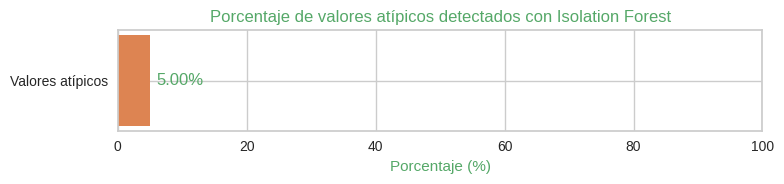

In [36]:
plt.figure(figsize=(8, 2))
plt.barh(
    ["Valores atípicos"],
    [percentage_outliers],
    color=PALETTE_C["secondary"]
)
plt.xlim(0, 100)
plt.xlabel("Porcentaje (%)", color=PALETTE_C["accent"])
plt.title(
    "Porcentaje de valores atípicos detectados con Isolation Forest",
    color=PALETTE_C["accent"]
)
plt.text(
    percentage_outliers + 1,
    0,
    f"{percentage_outliers:.2f}%",
    va="center",
    color=PALETTE_C["accent"]
)

plt.tight_layout()
plt.show()

Aunque se identificó un pequeño porcentaje de valores atípicos mediante Isolation Forest, se decidió conservarlos, ya que representan alojamientos reales con características particulares y podrían aportar información relevante para la formación de grupos.

Matriz de correlación

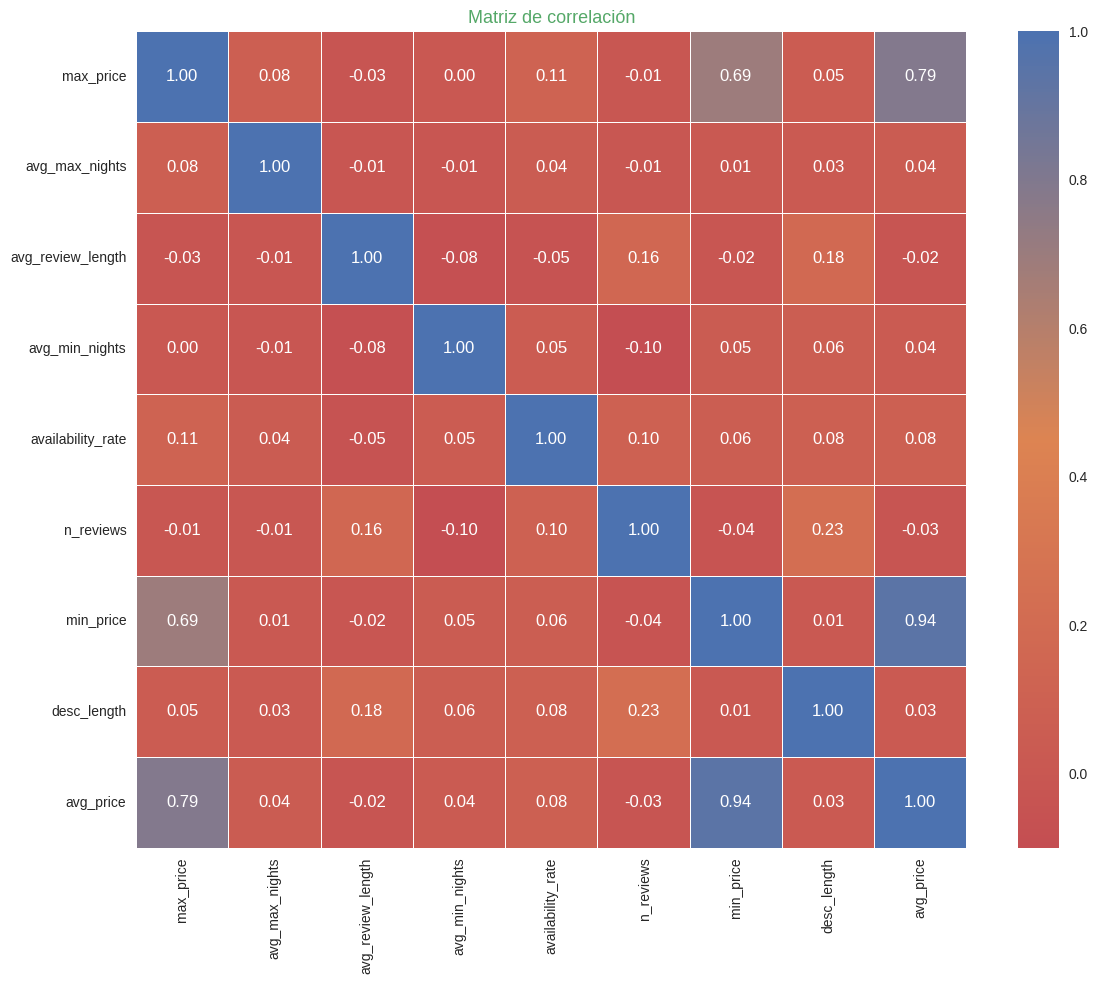

In [37]:
df_tmp = df.drop(columns=["listing_id"])
corr = df[var_num].corr()

cmap_ej1 = LinearSegmentedColormap.from_list(
    "ej1",
    [PALETTE_C["light"], PALETTE_C["secondary"], PALETTE_C["primary"]]
)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    cmap=cmap_ej1,
    annot=True,
    fmt=".2f",
    linewidths=0.5
)

plt.title("Matriz de correlación", color=PALETTE_C["accent"], fontsize=13)
plt.tight_layout()
plt.show()

* La mayoría de las variables presentan correlaciones bajas, lo que indica que capturan aspectos distintos de los listados de Airbnb.

* Se observa una alta correlación positiva entre las variables avg_price, min_price y max_price, lo cual es esperable, ya que todas representan distintas métricas del precio del alojamiento.

* Variables relacionadas con reseñas (n_reviews, avg_review_length) muestran correlaciones débiles con el precio, lo que sugiere que la actividad de los huéspedes no depende directamente del costo del alojamiento.

* La variable availability_rate presenta correlaciones bajas con el resto, indicando que la disponibilidad aporta información adicional y complementaria al análisis.

### Reducción de dimensiones

In [38]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[var_num])

In [39]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

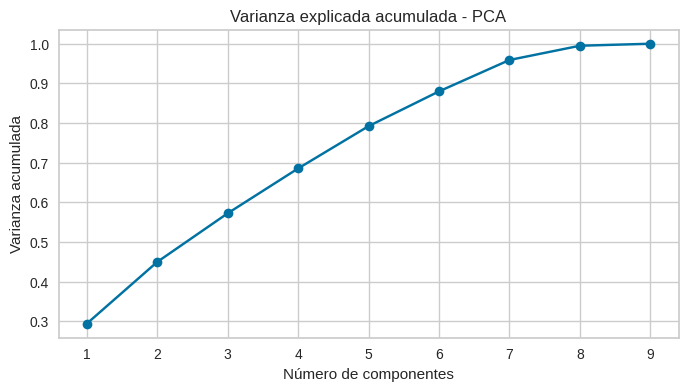

In [40]:
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8,4))
plt.plot(
    range(1, len(explained_variance) + 1),
    np.cumsum(explained_variance),
    marker='o'
)
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.title("Varianza explicada acumulada - PCA")
plt.show()

Se observa que los primeros cinco componentes principales capturan aproximadamente el 80% de la varianza total

Por ello, se seleccionaron cinco componentes para representar los datos en el análisis posterior, logrando una reducción significativa de dimensionalidad sin pérdida sustancial de información.

In [41]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

In [42]:
X_pca_df = pd.DataFrame(
    X_pca,
    columns=[f'PC{i}' for i in range(1, 6)],
    index=df.index
)

A partir del PCA se construyó un nuevo conjunto de variables que representan combinaciones lineales de las variables originales
Estas componentes serán utilizadas para clustering

## Número de clusters óptimo

CODO

/usr/local/lib/python3.12/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning:

No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.

/usr/local/lib/python3.12/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning:

No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning



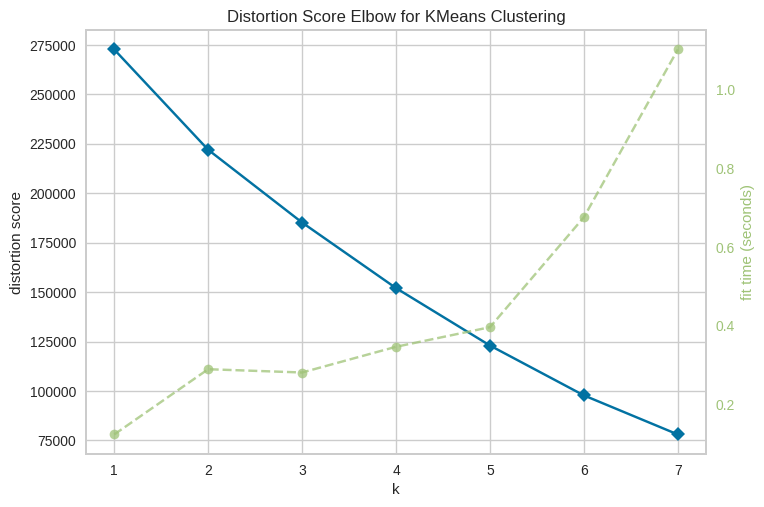

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [43]:
model = KMeans(init="k-means++", max_iter=50, n_init=10, random_state=42)
visualizer = KElbowVisualizer(model, k=(1,8))
visualizer.fit(X_pca_df)
visualizer.show()

El método del codo no muestra un punto de inflexión claramente definido, lo cual es consistente con la naturaleza continua de los datos.

Se observa una disminución más pronunciada de la distorsión hasta k = 3, a partir de la cual la mejora es leve. Por ello, se consideran k = 3 y k = 4 como valores posibles

SILUETA

Se utilizó como criterio adicional para seleccionar el número óptimo de clusters, ya que permite evaluar simultáneamente la cohesión interna y la separación entre los grupos.

El valor de k que maximiza este indicador se considera el más adecuado.

In [44]:
silueta = []

for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_pca_df)
    score = silhouette_score(X_pca_df, km.labels_, metric='euclidean')
    silueta.append(score)

df_silueta = pd.DataFrame({
    "N_Clusters": range(2,10),
    "score": silueta
})

import plotly.express as px

fig = px.line(
    df_silueta,
    x="N_Clusters",
    y="score",
    title="Número de clusters óptimo – Silueta"
)
fig.show()

Se observa que la siluedta calculada sobre los componentes principales presenta valores elevados, se observó que este comportamiento es producto de la amplificación de ciertas variables dominantes durante la reducción de dimensiones.

Al evaluar la silueta sobre los datos escalados originales, los valores obtenidos son más consistentes con un escenario realista de clustering.
Considerando el método del codo, la silueta y el criterio de interpretabilidad, se seleccionó **k = 3** como número óptimo de clusters.

### Clustering

Con base en el método del codo y la silueta se determinó que el número óptimo de clusters es k = 3, por lo que se aplicó el algoritmo K-means para agrupar los alojamientos.

KMEANS

In [50]:
km = KMeans(
    n_clusters=3,
    init='k-means++',
    random_state=42,
    n_init=10
)

km.fit(X_pca_df)

df_aux = df.copy()
df_aux['cluster'] = km.predict(X_pca_df)

df_aux['cluster'].value_counts()

cluster
0    38168
2       51
1       40
Name: count, dtype: int64

### Visualización de grupos

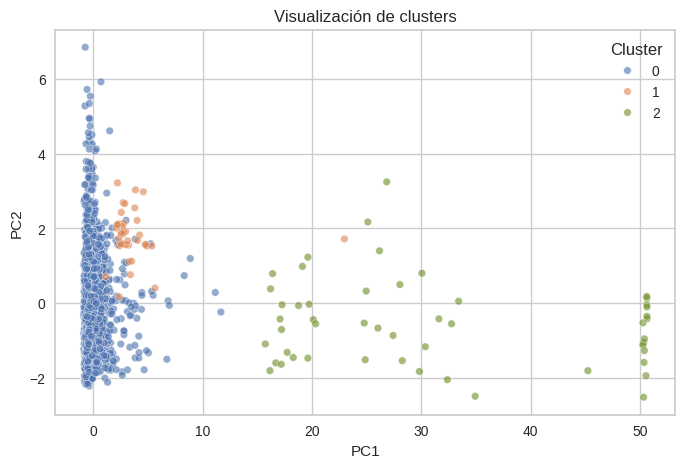

In [57]:
df_plot = pd.concat([
    df_aux[df_aux['cluster'] == 0].sample(2000, random_state=42),
    df_aux[df_aux['cluster'] != 0]
])

X_plot = X_pca_df.loc[df_plot.index]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x=X_plot['PC1'],
    y=X_plot['PC2'],
    hue=df_plot['cluster'],
    palette=FACTOR_COLORS[:3],
    alpha=0.6,
    s=30
)

plt.title("Visualización de clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

Debido al desbalance en el tamaño de los clusters, se utilizó un muestreo del cluster mayoritario con fines de visualización, lo cual permite apreciar de forma más clara la separación entre los grupos en el espacio de las componentes principales

### Perfilamiento

In [59]:
df_aux.groupby('cluster')[var_num].mean()

max_price  avg_max_nights  avg_review_length  avg_min_nights  \
cluster                                                                   
0         206.699984    1.681780e+05         200.167693       27.227526   
1        1266.500000    1.981863e+09         129.253760        2.882603   
2        7336.784314    8.957153e+02         125.435274       27.976685   

         availability_rate  n_reviews    min_price  desc_length    avg_price  
cluster                                                                       
0                 0.367296  23.310758   148.380712   690.139934   163.409728  
1                 0.855959  17.200000   247.275000   940.550000   542.006849  
2                 0.582326   5.588235  5550.196078   645.529412  6317.363309

0. Cluster 0: Estancias largas con mayor interacción

Agrupa alojamientos orientados a estancias largas, donde los huéspedes tienden a interactuar más y dejar reseñas detalladas. Son propiedades con menor rotación y una ocupación más constante.

Características principales:

* Requisitos de estancia mínima elevados

* Mayor número de reseñas y reseñas más extensas

* Disponibilidad baja, lo que sugiere ocupaciones prolongadas

* Precios bajos a medios en comparación con otros clusters

1. Cluster 1: Alojamientos premium y flexibles

Representa alojamientos de mayor nivel, bien descritos y con alta flexibilidad para los huéspedes. Están orientados a estancias cortas y muestran una mayor capacidad de adaptación a la demanda.

Características principales:

* Precios promedio y máximos elevados

* Alta disponibilidad

* Requisitos de estancia mínima bajos

* Descripciones más extensas

2. Cluster 2: Alojamientos de alto costo y baja rotación

Este grupo corresponde a alojamientos de alto costo, posiblemente dirigidos a un nicho específico de mercado. La baja cantidad de reseñas sugiere una menor rotación o estancias menos frecuentes.

Características principales:

* Precios promedio y mínimos muy altos

* Bajo número de reseñas

* Requisitos de estancia mínima elevados

* Disponibilidad media




El análisis de perfilamiento permite identificar tres grupos bien diferenciados de alojamientos en Airbnb, los cuales presentan patrones distintos en términos de precios, disponibilidad y comportamiento de los huéspedes.

Estos resultados confirman que es posible agrupar listados similares con base en las características que ofrecen.